## Retinanet

https://airctic.com/retinanet/

In [1]:
!wget https://github.com/OlafenwaMoses/FireNET/releases/download/v1.0/fire-dataset.zip -q

In [2]:
!unzip fire-dataset.zip

Archive:  fire-dataset.zip
replace fire-dataset/train/annotations/img (100).xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: fire-dataset/train/annotations/img (100).xml  
  inflating: fire-dataset/train/annotations/img (101).xml  
  inflating: fire-dataset/train/annotations/img (102).xml  
  inflating: fire-dataset/train/annotations/img (103).xml  
  inflating: fire-dataset/train/annotations/img (104).xml  
  inflating: fire-dataset/train/annotations/img (105).xml  
  inflating: fire-dataset/train/annotations/img (106).xml  
  inflating: fire-dataset/train/annotations/img (107).xml  
  inflating: fire-dataset/train/annotations/img (108).xml  
  inflating: fire-dataset/train/annotations/img (109).xml  
  inflating: fire-dataset/train/annotations/img (110).xml  
  inflating: fire-dataset/train/annotations/img (111).xml  
  inflating: fire-dataset/train/annotations/img (112).xml  
  inflating: fire-dataset/train/annotations/img (113).xml  
  inflating: fire-dataset/train/annotat

In [3]:
cp fire-dataset/validation/annotations/* fire-dataset/train/annotations/

In [4]:
cp fire-dataset/validation/images/* fire-dataset/train/images/

In [5]:
!rm  -r fire-dataset/validation/

In [6]:
!ls fire-dataset/train

annotations  images


In [ ]:
# !pip install  icedata
# !pip install icevision[all]
# !pip install git+git://github.com/airctic/icedata.git@master
# !pip install git+git://github.com/airctic/icevision.git@master

!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

--2021-09-10 04:24:18--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1244 (1.2K) [text/plain]
Saving to: ‘install_colab.sh.1’

install_colab.sh.1  100%[===================>]   1.21K  --.-KB/s    in 0s      

2021-09-10 04:24:18 (46.5 MB/s) - ‘install_colab.sh.1’ saved [1244/1244]

Installing icevision + dependencices for CUDA 10
Uninstalling some dependencies to prevent errors
Found existing installation: torchvision 0.9.0+cu101
Uninstalling torchvision-0.9.0+cu101:
  Successfully uninstalled torchvision-0.9.0+cu101
Found existing installation: fastai 2.3.1
Uninstalling fastai-2.3.1:
  Successfully uninstalled fastai-2.3.1
Installing some dependencies to prevent errors
- Installi

In [2]:
from icevision.all import *

import matplotlib.pyplot as plt
import icevision
icevision.__version__

'0.9.0a1'

In [3]:
data_dir = Path('fire-dataset/train')
data_dir

Path('fire-dataset/train')

In [4]:
images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

In [6]:
image_files = [i for i in images_dir.glob('*')]

In [7]:
annotation_files = [i for i in annotations_dir.glob('*')]

In [8]:
class_map = ClassMap(['fire'])

In [9]:
parser = parsers.VOCBBoxParser(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)
parser.class_map

<ClassMap: {'background': 0, 'fire': 1}>

In [10]:
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)

  0%|          | 0/502 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/502 [00:00<?, ?it/s]

In [11]:
# objects = aggregate_records_objects(train_records + valid_records)

In [12]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

The Dataset class combines the records and transforms.

In [13]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [14]:
model_type = models.torchvision.retinanet
backbone = model_type.backbones.resnet50_fpn

In [15]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Each model has its own dataloader (a pytorch `DataLoader`) that could be customized: the dataloaders for the RCNN models have a custom collate function.

In [16]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [18]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.00015848931798245758)

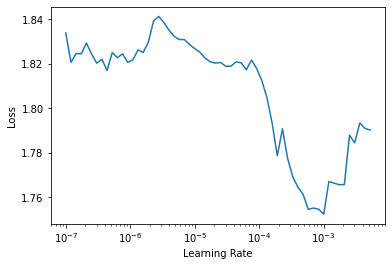

In [19]:
learn.lr_find()

The fastai fine_tune method is useful when you have a pre-trained model, which we are using. It does an initial epoch where it freezes everything except its final layers. It then carries on for the indicated number of epochs using a differential learning rate to train the whole model. It adjusts the learning rate both across the layers of the model as well as across the epochs. This can give excellent results with reduced training time.

In [20]:
learn.fine_tune(100, 1e-4, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,1.561755,1.455938,0.006112,00:39


epoch,train_loss,valid_loss,COCOMetric,time
0,1.198604,1.166240,0.011256,01:04
1,1.129753,1.142837,0.014214,00:59
2,1.070325,1.105864,0.024564,00:59
3,1.034768,1.085028,0.022228,00:58
4,1.033983,1.031195,0.037490,00:58
5,0.994163,1.055735,0.034726,00:59
6,0.965756,0.984312,0.049393,00:58
7,0.928752,1.009942,0.038624,00:59
8,0.908246,0.949988,0.072743,00:58
9,0.879640,0.931019,0.053750,00:58


At 100 epochs reaching 0.27

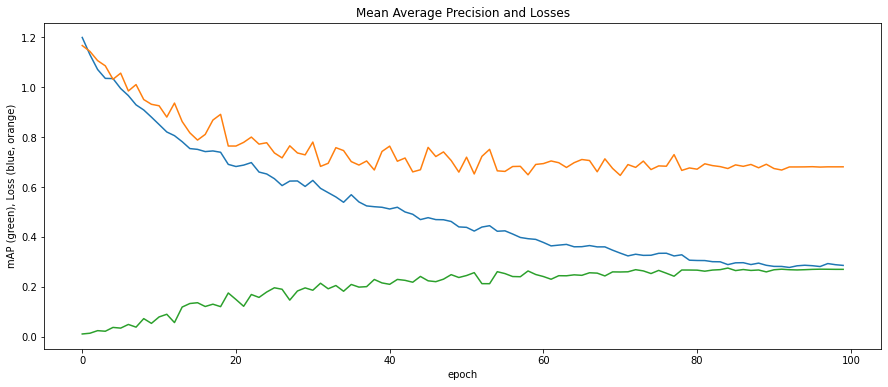

In [21]:

def plot_metrics(learn, title, x, y):
  fig, ax = plt.subplots(1,1,figsize=(15,6))
  ax.plot(L(learn.recorder.values).itemgot())
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)

plot_metrics(learn, 'Mean Average Precision and Losses', 0,-0.05)

In [22]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/26 [00:00<?, ?it/s]

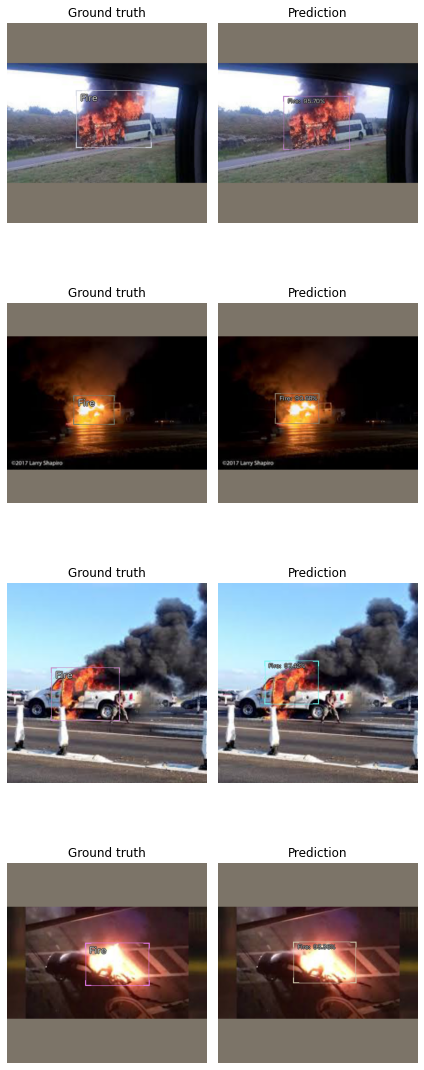

In [23]:
show_preds(preds=preds[:4])

https://airctic.github.io/icedata/how-to/#how-to-save-trained-weights-in-google-colab

In [24]:

## Saving a Model on Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

torch.save(model.state_dict(), root_dir/'models/icedata/retinanet_fire.pth')

Mounted at /content/gdrive


123 MB